In [3]:
import numpy as np
import pandas as pd

data = pd.read_csv('movies.csv')

In [4]:
# Get information about the current dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63000 entries, 0 to 62999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    63000 non-null  int64  
 1   title                 63000 non-null  object 
 2   vote_average          63000 non-null  float64
 3   vote_count            63000 non-null  int64  
 4   status                63000 non-null  object 
 5   release_date          62973 non-null  object 
 6   revenue               63000 non-null  int64  
 7   runtime               63000 non-null  int64  
 8   budget                63000 non-null  int64  
 9   original_language     63000 non-null  object 
 10  popularity            63000 non-null  float64
 11  genres                62517 non-null  object 
 12  production_companies  56870 non-null  object 
 13  production_countries  60859 non-null  object 
 14  spoken_languages      62046 non-null  object 
dtypes: float64(2), int6

In [5]:
data.isnull()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,original_language,popularity,genres,production_companies,production_countries,spoken_languages
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62995,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
62996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


<Axes: >

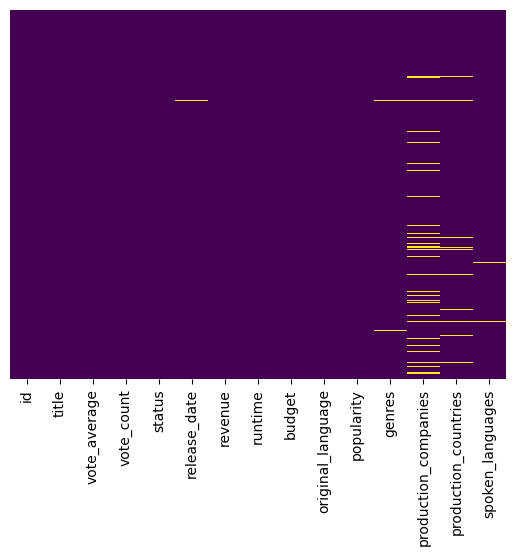

In [10]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')
# from this heatmap we can see that production_companies contains plenty missing values

<Axes: >

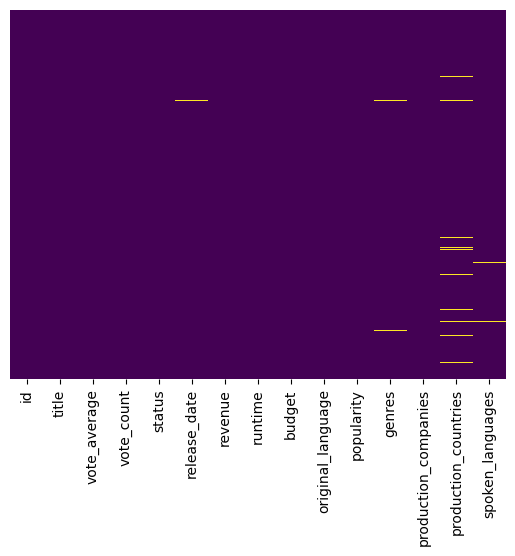

In [13]:
# Since there are many missing values but we need the column for analysis we will not drop it, just categorise the NAN's as unknown
# This is selected as the 'most frequent' strategy would does not preserve the information about missingness
data['production_companies'] = data['production_companies'].fillna('Unknown')
sns.heatmap(data.isnull(),yticklabels=False, cbar=False, cmap='viridis')

In [17]:
print(data['production_countries'].apply(type).value_counts())
print(data['status'].apply(type).value_counts())
print(data['genres'].apply(type).value_counts())
print(data['spoken_languages'].apply(type).value_counts())


production_countries
<class 'str'>      60859
<class 'float'>     2141
Name: count, dtype: int64
status
<class 'str'>    63000
Name: count, dtype: int64
genres
<class 'str'>      62517
<class 'float'>      483
Name: count, dtype: int64
spoken_languages
<class 'str'>      62046
<class 'float'>      954
Name: count, dtype: int64
